# Examples for vireoSNP

In [1]:
import vireoSNP
import numpy as np

from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [2]:
cell_vcf = vireoSNP.load_VCF("../data/cells.cellSNP.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

AD = cell_dat['AD']
DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [3]:
AD = mmread("../data/cellSNP_mat/cellSNP.tag.AD.mtx").tocsc()
DP = mmread("../data/cellSNP_mat/cellSNP.tag.DP.mtx").tocsc()

## Run vireoSNP
Note, `AD` and `DP` are sparse matrices, not `numpy.array`

You need to consider how many allelic ratio categories in your data and your prior. For example, you could assume there are three:

```python
theta_prior = np.array([[0.01, 1], [1, 1], [1, 0.01]])
```

or three allelic ratios:

```python
theta_prior = np.array([[0.01, 1], [1, 2], [1, 1], [2, 1], [1, 0.01]])
```

Also, you need to guess how many donors (or clones) in your data sets.

If the allelic ratios are different across variants even with the same allelic category (i.e. genotype), please add `ASE_mode=True`

In [4]:
theta_prior = np.array([[0.01, 1], [1, 1], [1, 0.01]])

# res = vireoSNP.vireo_core(AD, DP, n_donor=4, learn_GT=True,
#                           theta_prior=theta_prior, learn_theta=True, 
#                           check_doublet=False)

res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
                           n_extra_donor=0, #ASE_mode=True,
                           theta_prior=theta_prior, learn_theta=True, 
                           n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 4 clusters...
donor3	donor1	donor2	donor0
248	241	232	231
[vireo] warm-up: lower bound ranges [-34370.0, -28574.6, -22125.0]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 28 iterations; lower bound -22071.0
[vireo] beta parameters for binomial rate:
[[440.6 27599.9]
 [17472.2 20458.0]
 [20419.2 1318.1]]


## Clone assignment probability

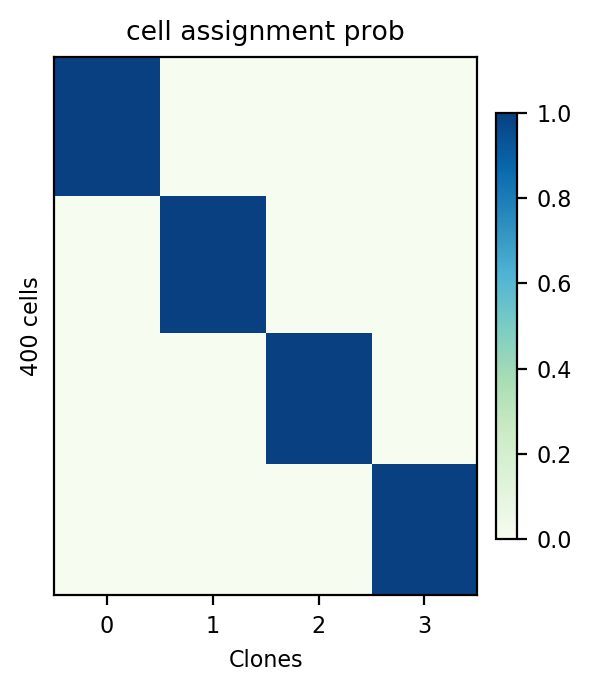

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(3, 3.5), dpi=200)
im = heat_matrix(res['ID_prob'], cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Clones")
plt.ylabel("400 cells")
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()